# Agroo

A agrotech solution to detect whether a plant is infected by worms or not using machine learning

### Importing libraries we will be using

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import *

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from random import shuffle 
%matplotlib inline

Setting the seed to ensure the reproducibility of our code

In [3]:
def seedall(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONSEED"] = str(seed)

seedall(47)

Setting some parameters

In [9]:
# setting batch size to 21
batch_size = 16

# run parallelism
num_jobs = 0

# setting paths
images_path = "Agroo"
train_labels = "Agroo-train.csv"
test_labels = "Agroo-Test.csv"

# Setting validation size
val_size = 0.3

In [10]:
df_train = pd.read_csv(train_labels)
df_test = pd.read_csv(test_labels)

In [11]:
df_train.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [12]:
df_train.shape

(1619, 2)

In [13]:
df_test.shape

(1080, 1)

Defining transformations for our model

In [14]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),  # To randomly flip the images horizontally
                                transforms.RandomRotation(25),      # To randomly rotate the images by 25 degrees
                                transforms.Resize([224, 224]),     # To convert the images to 224 by 224
                                transforms.ToTensor(),              # To convert the images to tensors  
                                transforms.Normalize([0.3692, 0.5223, 0.2339], [0.1710, 0.1216, 0.1737]),
                               ])

In [15]:
# sample_img = "Agroo/id_2x28dk29uzeoj.jpg"
# img = Image.open(sample_img)
# trans = transforms.Compose([transforms.ToTensor()])
# img = trans(img)

In [16]:
img.mean([1,2])

NameError: name 'img' is not defined

In [11]:
img.std([1,2])

tensor([0.1710, 0.1216, 0.1737])

Defining a cutom ImageLoader to pair the images with their labels in the train_labels

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, label, img_dir, transform):
        self.img_labels = pd.read_csv(label)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        label = self.img_labels.iloc[idx,1]
        image = self.transform(image)
        return image, label

Next, let's load the data into the imageloader and split into train and validation sets 

In [18]:
from torch.utils.data.sampler import SubsetRandomSampler

In [19]:
data = CustomImageDataset(train_labels, images_path, transform)

# Len of the dataset
data_len = len(data)
indices = [x for x in range(data_len)]

# Shuffling the indices
np.random.shuffle(indices)

# Creating split for train and validation sets
split = int(np.floor(data_len * val_size))

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)



In [20]:
class LimitDataset(Dataset):
    def __init__(self, dataset, n):
        self.dataset = dataset
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        return self.dataset[i]

In [21]:
# train = LimitDataset(data, 1200)
# val = LimitDataset(data, 480)

train_loader = DataLoader(data, batch_size=batch_size,
                         sampler=train_sampler, num_workers=num_jobs)

val_loader = DataLoader(data, batch_size=batch_size,
                         sampler=val_sampler, num_workers=num_jobs)

In [22]:
len(train_idx)

1134

In [23]:
len(val_loader)

31

In [24]:
images, labels = next(iter(train_loader))

In [25]:
a = np.array([0.3692, 0.5223, 0.2339])
a = np.reshape(1/a, [3,1,1])
s = [0.1710, 0.1216, 0.1737]
s = np.reshape(s, [3,1,1])

In [26]:
# Helper function to unnormalize the data
def imshow(img):
    img = img/a + s
    plt.imshow(np.transpose(img, (1,2,0)))

### Visualising our models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

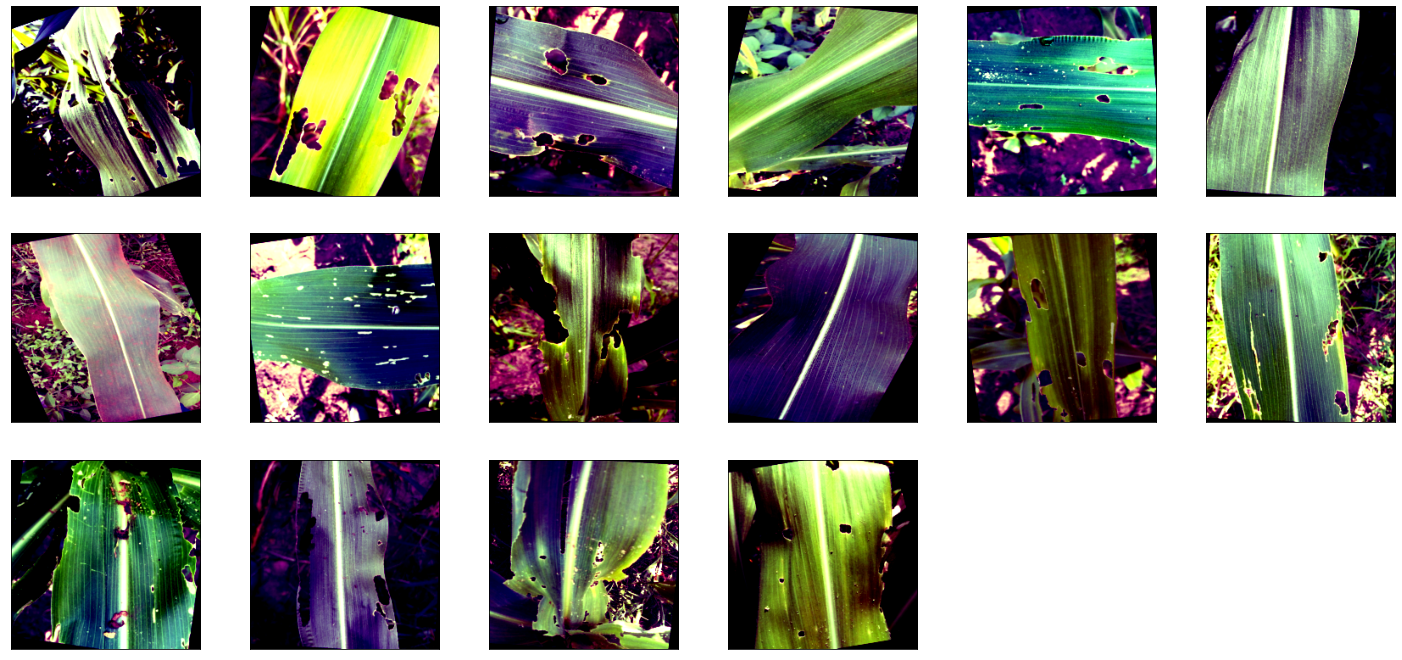

In [27]:
img = np.array(images)

fig = plt.figure(figsize=(25,16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4,6, idx+1, xticks=[], yticks=[])
    imshow(img[idx])

In [28]:
print(labels)
print(len(labels))

tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])
16


In [92]:
conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2)
relu = nn.ReLU()

In [93]:
a = conv1(images)
a = relu(a)
a.shape

torch.Size([16, 16, 226, 226])

In [85]:
images.shape

torch.Size([16, 3, 224, 224])

## Defining a models

### 1. Custom CNN

In [41]:
class ConvNets(nn.Module):
    def __init__(self):
        super(ConvNets, self).__init__()
        # convolution layer (sees 224 * 224 * 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # convolution layer (sees 112 * 112 * 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # convolution layer (sees 56 * 56 * 32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Relu activation function
        self.relu = nn.ReLU()
        # Maxpool function to reduce the kernel size
        self.maxpool = nn.MaxPool2d(2)
        # Linear layer (sees 28 * 28 * 64 tensors)
        self.fc = nn.Linear(28 * 28 * 64, 102)
        # Final out layer (see 102 tensors and return prediction 1)
        self.output = nn.Linear(102,1)
        # sigmoid activation function for final prediction
        self.sigmoid = nn.Sigmoid()
        # dropout function to reduce overfitting
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # first convolution layer
        out = self.maxpool(self.relu(self.conv1(x)))
        # Second convoluton layer
        out = self.maxpool(self.relu(self.conv2(out)))
        # Third convolution layer
        out = self.maxpool(self.relu(self.conv3(out)))
        # flattening the output
        out = out.view(-1, 28 * 28 * 64)
        # adding dropout to the model
        out = self.dropout(out)
        # first fully connected layer
        out = self.relu(self.fc(out))
        # adding dropout to the model
        out = self.dropout(out)
        # final fully connected layer with sigmoid function
        out = self.sigmoid(self.output(out))
        return out

In [42]:
ConvNets()

ConvNets(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=50176, out_features=102, bias=True)
  (output): Linear(in_features=102, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [33]:
model()

model(
  (layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=53824, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), "best_model.bin")
        self.val_loss_min = val_loss

In [48]:
def train(model, train_loader, val_loader, lr, num_epochs):
    
    # Creating empty lists where we will save our train loss, validation loss and validation accuracy
    train_loss, val_loss, val_accuracy = [], [], []
    
    # setting device to cuda if available, if not, cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Setting criterion to CrossEntropy
    criterion = nn.BCELoss()
    
    # Setting our loss function as Adam Optimiser
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    early_stopping = EarlyStopping(patience=5, verbose= True)
    
    directory = "models/"
    # for the range of our epoch
    for epoch in tqdm(range(num_epochs)):
        if not os.path.exists(directory):
            os.makedirs(directory)
        epoch_loss = 0
        count = 0
        model.train()
        # Load images in the dataloader
        for images, labels in train_loader:
            # Move data and model to device
            model = model.to(device)
            images = images.to(device)
            labels = labels.to(device)

            #forward pass
            t_output = model(images)
            count += 1

            # calculating the loss of our model
            loss = criterion(t_output, labels.float().reshape(-1,1))

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= count
        train_loss.append(epoch_loss)
        
        
        # Setting to evaluatione mode
        accuracy = 0
        val_loss_ = 0
        count = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                # Move data and model to device
                images = images.to(device)
                labels = labels.to(device)

                #forward pass
                v_output = model(images)
                count += 1

                # calculating the loss of our model
                loss = criterion(v_output, labels.float().reshape(-1,1))
                val_loss_ += loss.item()

                # getting accuracy, converting both labels and predictions to same datatype and shape
                labels = labels.type(torch.float)
                v_output = v_output.round().flatten()
                equals = v_output == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            val_loss_ /= count
            val_loss.append(val_loss_)
            accuracy /= count
            val_accuracy.append(accuracy)
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs), 
              "Training Loss: {:.3f}.. ".format(epoch_loss), 
              "Test Loss: {:.3f}.. ".format(val_loss_),
              "Test Accuracy: {:.3f}".format(accuracy))
            
            early_stopping(val_loss_, model)  
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {x}.......")
                break
    return train_loss, val_loss, val_accuracy


In [49]:
# model = model()
model = ConvNets()
learning_rate= 0.001
num_epochs = 10
train_loss, val_loss, val_accuracy = train(model, train_loader, val_loader, learning_rate, num_epochs)

 10%|█         | 1/10 [01:59<17:52, 119.13s/it]

Epoch: 1/10..  Training Loss: 0.650..  Test Loss: 0.476..  Test Accuracy: 0.774
Validation loss decreased (inf --> 0.476124).  Saving model ...


 20%|██        | 2/10 [04:05<16:27, 123.42s/it]

Epoch: 2/10..  Training Loss: 0.423..  Test Loss: 0.383..  Test Accuracy: 0.828
Validation loss decreased (0.476124 --> 0.382518).  Saving model ...


 30%|███       | 3/10 [06:16<14:48, 126.99s/it]

Epoch: 3/10..  Training Loss: 0.362..  Test Loss: 0.277..  Test Accuracy: 0.880
Validation loss decreased (0.382518 --> 0.277384).  Saving model ...


 40%|████      | 4/10 [09:00<14:08, 141.34s/it]

Epoch: 4/10..  Training Loss: 0.269..  Test Loss: 0.228..  Test Accuracy: 0.901
Validation loss decreased (0.277384 --> 0.228393).  Saving model ...


 50%|█████     | 5/10 [11:45<12:29, 149.90s/it]

Epoch: 5/10..  Training Loss: 0.219..  Test Loss: 0.192..  Test Accuracy: 0.923
Validation loss decreased (0.228393 --> 0.191932).  Saving model ...


 60%|██████    | 6/10 [14:11<09:54, 148.56s/it]

Epoch: 6/10..  Training Loss: 0.190..  Test Loss: 0.204..  Test Accuracy: 0.905
EarlyStopping counter: 1 out of 5


 70%|███████   | 7/10 [16:32<07:19, 146.35s/it]

Epoch: 7/10..  Training Loss: 0.172..  Test Loss: 0.149..  Test Accuracy: 0.938
Validation loss decreased (0.191932 --> 0.148617).  Saving model ...


 80%|████████  | 8/10 [18:45<04:43, 141.99s/it]

Epoch: 8/10..  Training Loss: 0.146..  Test Loss: 0.168..  Test Accuracy: 0.931
EarlyStopping counter: 1 out of 5


 90%|█████████ | 9/10 [20:55<02:18, 138.18s/it]

Epoch: 9/10..  Training Loss: 0.133..  Test Loss: 0.133..  Test Accuracy: 0.956
Validation loss decreased (0.148617 --> 0.132600).  Saving model ...


100%|██████████| 10/10 [23:14<00:00, 139.50s/it]

Epoch: 10/10..  Training Loss: 0.126..  Test Loss: 0.126..  Test Accuracy: 0.948
Validation loss decreased (0.132600 --> 0.125933).  Saving model ...


In [52]:
class CustomImageDataset(Dataset):
    def __init__(self, label, img_dir, transform):
        self.img_labels = pd.read_csv(label)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        label = self.img_labels.iloc[idx,0]
        image = self.transform(image)
        return image, label

In [53]:
test_data = CustomImageDataset(test_labels, images_path, transform)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_jobs)

In [54]:
location = "best_model.bin"
def load_model(location):
    model = ConvNets()
    state_dict = torch.load(location)
    model.load_state_dict(state_dict)
    return model

In [55]:
model = load_model(location)

In [68]:
def predict(model, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    predictions = dict()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # Move data and model to device
            images = images.to(device)

            #forward pass
            output = model(images)

            # getting accuracy, converting both labels and predictions to same datatype and shape
            output = output.round().flatten()
            for label, result in zip(labels, output):
                predictions[label] = result
                
    return predictions

In [69]:
predictions = predict(model, test_loader)

100%|██████████| 68/68 [01:01<00:00,  1.11it/s]


In [77]:
int(predictions["id_00exusbkgzw1b.jpg"])


0

In [82]:
for key, value in predictions.items():
    predictions[key] = int(value)

In [84]:
df = pd.Series(predictions)

In [86]:
df.to_csv("Agroo-predictions.csv")

In [231]:
a

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<ReshapeAliasBackward0>)

In [221]:
equals = a == labels.type(torch.float)

equals

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [ ]:

torch.mean(equals.type(torch.FloatTensor))

In [192]:
layer1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2)
layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2)
layer3 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=2)
relu = nn.ReLU()
maxpool = nn.MaxPool2d(2)
fc = nn.Linear(28*28*64, 1)
sigmoid = nn.Sigmoid()
        

In [193]:
def forward(x):
    out = layer1(x)
    out = relu(out)
    out = maxpool(out)
    out = layer2(out)
    out = relu(out)
    out = maxpool(out)
    out = sigmoid(out)
    return out

In [194]:
b = forward(sample)
b.shape

torch.Size([16, 32, 57, 57])

In [56]:
at = dict()

TypeError: 'dict' object is not callable

In [369]:
help(datetime)

Help on class datetime in module datetime:

class datetime(date)
 |  datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
 |  
 |  The year, month and day arguments are required. tzinfo may be None, or an
 |  instance of a tzinfo subclass. The remaining arguments may be ints.
 |  
 |  Method resolution order:
 |      datetime
 |      date
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __radd__(self, value

'2022-07-23 09:38:39.732725'

In [378]:
datetime.time()

TypeError: unbound method datetime.time() needs an argument